<a href="https://colab.research.google.com/github/arazm21/ML-homework_4/blob/main/expression_notebook_second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# loading the data and organising it

In [1]:
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Mounted at /content/drive
 86% 246M/285M [00:00<00:00, 557MB/s] 
100% 285M/285M [00:00<00:00, 607MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [2]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 111.0 MB/s eta 0:00:00


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [4]:
import torch
from torch.utils.data import Dataset, Subset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Subset

class ExpressionDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, indices=None):
        self.data = pd.read_csv(csv_file)

        if indices is not None:
            self.data = self.data.iloc[indices].reset_index(drop=True)

        self.images = self.data['pixels'].apply(
            lambda x: np.fromstring(x, sep=' ', dtype=np.uint8).reshape(48, 48)
        )
        self.images = torch.tensor(np.stack(self.images.values), dtype=torch.float32).unsqueeze(1) / 255.0
        self.labels = torch.tensor(self.data['emotion'].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


def get_data(csv_file="train.csv", slice=5, train=True, val_ratio=0.2, random_state=42):
    # Load full train.csv data
    full_data = pd.read_csv(csv_file)
    indices = list(range(len(full_data)))

    # Stratified split indices for train/validation
    train_indices, val_indices = train_test_split(
        indices,
        test_size=val_ratio,
        stratify=full_data['emotion'],
        random_state=random_state
    )

    # Select which indices to use
    selected_indices = train_indices if train else val_indices

    # Create dataset with selected indices
    dataset = ExpressionDataset(csv_file, indices=selected_indices)

    # Slice dataset if requested
    sliced_indices = list(range(0, len(dataset), slice))
    return Subset(dataset, sliced_indices)


def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        pin_memory=True,
                        num_workers=2)
    return loader


## test that loading was ok

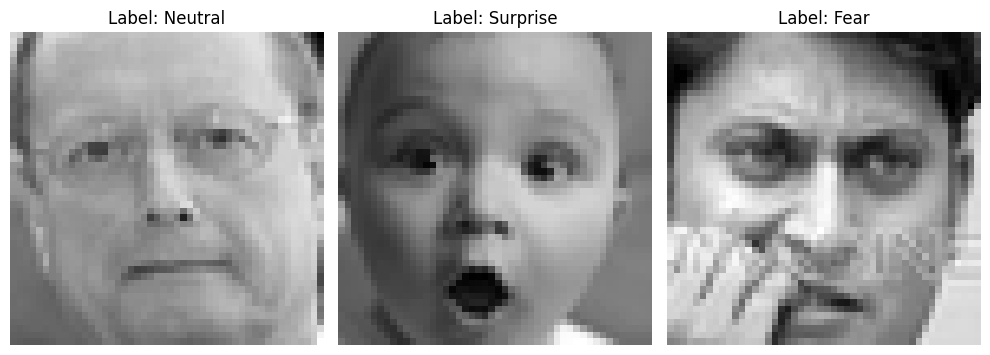

In [5]:
# Load and create loader
dataset = get_data(slice=1, train=False)
loader = make_loader(dataset, batch_size=3)

# Get a batch
images, labels = next(iter(loader))

# Class names from FER2013
emotion_names = [
    "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
]

# Plot the first 3 images
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {emotion_names[labels[i].item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# connecting WANDB

In [6]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arazm21 (arazm21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# different attempted architectures

In [8]:
# import torch.nn as nn

# class ConvNet_super_simple(nn.Module):
#     def __init__(self, kernels, classes=7):
#         super(ConvNet_super_simple, self).__init__()

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         # Assuming 48x48 input, after two 2x2 poolings -> 48/2/2 = 12x12
#         self.fc = nn.Linear(12 * 12 * kernels[1], classes)

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out
import torch
import torch.nn as nn

class ConvNet_Improved(nn.Module):
    def __init__(self, kernels, classes=7):
        super(ConvNet_Improved, self).__init__()

        # First conv block
        self.conv1 = nn.Conv2d(1, kernels[0], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(kernels[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second conv block
        self.conv2 = nn.Conv2d(kernels[0], kernels[1], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(kernels[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third conv block
        self.conv3 = nn.Conv2d(kernels[1], kernels[2], kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(kernels[2])
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Assuming 48x48 input → 3 poolings: 48 → 24 → 12 → 6
        self.flattened_dim = 6 * 6 * kernels[2]
        self.fc = nn.Linear(self.flattened_dim, classes)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


## resnet

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, dropout_rate=0.2):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        self.dropout = nn.Dropout2d(dropout_rate)

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        out = self.dropout(out)  # ✅ Dropout after residual addition
        return out

class SimpleResNet15(nn.Module):
    def __init__(self, in_channels=1, num_classes=7, dropout_rate=0.3):
        super(SimpleResNet15, self).__init__()

        self.entry = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layers = nn.Sequential(
            ResidualBlock(32, 128, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(128, 256, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(256, 512, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(512, 1024, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(1024, 2048, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(2048, 2048, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(2048, 1024, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(1024, 512, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(512, 256, downsample=True, dropout_rate=dropout_rate),

            ResidualBlock(512, 256, downsample=False, dropout_rate=dropout_rate),
            ResidualBlock(256, 128, downsample=False, dropout_rate=dropout_rate),
            ResidualBlock(128, 64, downsample=False, dropout_rate=dropout_rate),
            ResidualBlock(64, 32, downsample=False, dropout_rate=dropout_rate)
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.entry(x)
        x = self.layers(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


## googlenet(mini)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MiniInception(nn.Module):
    def __init__(self, in_ch, c1, c3red, c3, pool_proj):
        super().__init__()
        # 1×1 branch
        self.b1 = nn.Conv2d(in_ch, c1, kernel_size=1)
        # 1×1 → 3×3 branch
        self.b2_1 = nn.Conv2d(in_ch, c3red, kernel_size=1)
        self.b2_2 = nn.Conv2d(c3red, c3,   kernel_size=3, padding=1)
        # pool → 1×1 branch
        self.b3_pool = nn.MaxPool2d(3, stride=1, padding=1)
        self.b3_proj = nn.Conv2d(in_ch, pool_proj, kernel_size=1)

        self.bn = nn.BatchNorm2d(c1 + c3 + pool_proj)

    def forward(self, x):
        b1 = self.b1(x)
        b2 = self.b2_2(F.relu(self.b2_1(x)))
        b3 = self.b3_proj(self.b3_pool(x))
        out = torch.cat([b1, b2, b3], dim=1)
        return F.relu(self.bn(out))


class MiniGoogLeNet(nn.Module):
    def __init__(self, num_classes=7, aux_on=True):
        super().__init__()
        self.aux_on = aux_on

        # ---- stem ----
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 48→24
        )

        # ---- two Inception blocks ----
        self.inc1 = MiniInception(32, c1=16, c3red=16, c3=24, pool_proj=16)  # outputs 56
        self.inc2 = MiniInception(56, c1=32, c3red=24, c3=32, pool_proj=24)  # outputs 88

        # auxiliary head (after inc1)
        if aux_on:
            self.aux = nn.Sequential(
                nn.AdaptiveAvgPool2d( (4,4) ),
                nn.Conv2d(56, 32, 1), nn.ReLU(),
                nn.Flatten(),
                nn.Linear(32*4*4, 128), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(128, num_classes)
            )

        # ---- classifier head ----
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc   = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(88, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)            # → [B,32,24,24]
        x1 = self.inc1(x)           # → [B,56,24,24]

        if self.training and self.aux_on:
            aux_out = self.aux(x1)

        x2 = F.max_pool2d(x1, 2, 2) # → [B,56,12,12]
        x2 = self.inc2(x2)          # → [B,88,12,12]

        x3 = self.pool(x2)          # → [B,88,1,1]
        main_out = self.fc(x3)      # → [B,num_classes]

        return (main_out, aux_out) if (self.training and self.aux_on) else main_out


# geting everything ready

In [10]:
def make(config):
    # Make the data
    train_dataset = get_data(train=True)
    test_dataset = get_data(train=False)
    train_loader = make_loader(train_dataset, batch_size=config.batch_size)
    test_loader = make_loader(test_dataset, batch_size=config.batch_size)

    # Make the model
    model = SimpleResNet().to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    return model, train_loader, test_loader, criterion, optimizer

In [11]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

## early stop training

In [39]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def validate(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total
    return val_loss, val_acc

def train(model, train_loader, val_loader, criterion, optimizer, config):
    wandb.watch(model, criterion, log="all", log_freq=10)

    early_stopper = EarlyStopping(patience=15, min_delta=0.001)

    example_ct = 0
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        model.train()
        running_correct = 0
        running_total = 0

        for _, (images, labels) in enumerate(train_loader):
            loss, batch_correct, batch_total = train_batch(images, labels, model, optimizer, criterion)
            example_ct += len(images)
            batch_ct += 1

            running_correct += batch_correct
            running_total += batch_total

            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
                print(f"batch number: {batch_ct + 1}")

        train_acc = running_correct / running_total

        # ⏱️ Validate at the end of the epoch
        val_loss, val_acc = validate(model, val_loader, criterion)
        wandb.log({
            "epoch": epoch,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "train_accuracy": train_acc
        })
        print(f"Epoch {epoch + 1}: val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}, train_acc = {train_acc:.4f}")

        # Check early stopping
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)

    return loss, correct, total

## normal training

In [18]:
# def train(model, loader, criterion, optimizer, config):
#     # Tell wandb to watch what the model gets up to: gradients, weights, and more!
#     wandb.watch(model, criterion, log="all", log_freq=10)

#     # Run training and track with wandb
#     total_batches = len(loader) * config.epochs
#     example_ct = 0  # number of examples seen
#     batch_ct = 0
#     for epoch in tqdm(range(config.epochs)):
#         for _, (images, labels) in enumerate(loader):

#             loss = train_batch(images, labels, model, optimizer, criterion)
#             example_ct +=  len(images)
#             batch_ct += 1

#             # Report metrics every 25th batch
#             if ((batch_ct + 1) % 25) == 0:
#                 train_log(loss, example_ct, epoch)
#                 print(f"batch number: {batch_ct + 1}")
def validate(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total
    return val_loss, val_acc
def train(model, train_loader, val_loader, criterion, optimizer, config):
    wandb.watch(model, criterion, log="all", log_freq=10)

    example_ct = 0
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_accumulator = 0.0

        for _, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            example_ct += len(images)
            batch_ct += 1

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Accumulate loss for the epoch
            train_loss_accumulator += loss.item() * images.size(0)

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
                print(f"batch number: {batch_ct + 1}")

        # Final training metrics for the epoch
        train_loss = train_loss_accumulator / train_total
        train_acc = train_correct / train_total

        # ⏱️ Validation step
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Log both train & val metrics
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        print(f"Epoch {epoch + 1}: "
              f"train_loss = {train_loss:.4f}, train_accuracy = {train_acc:.4f}, "
              f"val_loss = {val_loss:.4f}, val_accuracy = {val_acc:.4f}")
def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)

    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [13]:
def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")

        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

In [50]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="expression_dataset_better_eval",
                    config=hyperparameters,
                    name = "early_stop_test_3"):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      # train(model, train_loader, criterion, optimizer, config)

      # # and test its final performance
      # test(model, test_loader)
      train(model, train_loader, test_loader, criterion, optimizer, config)
      test(model, test_loader)  # final test; you can use actual test set here if available


    return model

In [51]:
config = dict(
    epochs=250,
    classes=7,
    #kernels=[32, 64, 128],
    batch_size=256,
    learning_rate=1e-4,
    dataset="Facial Expression Recognition",
    architecture="simple_resnet_bigger_250_epochs")

# train!

In [52]:
model = model_pipeline(config)

SimpleResNet(
  (entry): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout): Dropout2d(p=0.3, inplace=False)
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: val_loss = 1.9451, val_acc = 0.1680, train_acc = 0.1454
Loss after 06130 examples: 1.988
batch number: 25
Epoch 2: val_loss = 1.9284, val_acc = 0.1671, train_acc = 0.1474
Loss after 12516 examples: 1.980
batch number: 50
Epoch 3: val_loss = 1.9203, val_acc = 0.1828, train_acc = 0.1508
Epoch 4: val_loss = 1.9165, val_acc = 0.1784, train_acc = 0.1456
Loss after 18888 examples: 1.987
batch number: 75
Epoch 5: val_loss = 1.9101, val_acc = 0.1810, train_acc = 0.1578
Loss after 25274 examples: 1.960
batch number: 100
Epoch 6: val_loss = 1.9040, val_acc = 0.1802, train_acc = 0.1624
Loss after 31660 examples: 1.993
batch number: 125
Epoch 7: val_loss = 1.9003, val_acc = 0.1810, train_acc = 0.1672
Epoch 8: val_loss = 1.8955, val_acc = 0.1854, train_acc = 0.1676
Loss after 38032 examples: 1.948
batch number: 150
Epoch 9: val_loss = 1.8879, val_acc = 0.2132, train_acc = 0.1785
Loss after 44418 examples: 1.953
batch number: 175
Epoch 10: val_loss = 1.8854, val_acc = 0.2263, train_acc = 0.

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇█████
loss,██▆▆▅▄▆▄▅▅▄▅▄▅▃▅▅▄▄▃▄▃▃▃▂▄▄▃▄▂▂▃▁▂▁▂▃▁▁▂
test_accuracy,▁
train_accuracy,▁▂▃▄▃▄▄▄▄▄▃▄▄▄▅▅▄▅▅▅▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇█▇█▇█
val_accuracy,▁▁▂▅▅▆▅▅▆▆▇▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇███▇▇███▇
val_loss,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,105
loss,1.75486
test_accuracy,0.26545
train_accuracy,0.28385
val_accuracy,0.26545
